# DistilBERT Emotion Classifier — Phase 2
This notebook trains the emotion classification model using the GoEmotions dataset.
Model: `distilbert-base-uncased`
Task: Multi-label emotion classification
Objective: Predict emotions from user text as input to the AI Emotional Advisor.
Dataset: GoEmotions (27 emotion labels + neutral)


### Notebook Steps
1. Install & import libraries
2. Mount Google Drive
3. Load & preprocess GoEmotions dataset
4. Tokenize text using DistilBERT tokenizer
5. Create train/validation datasets
6. Define model (`AutoModelForSequenceClassification`)
7. Training configuration + Trainer setup
8. Train model
9. Evaluate (metrics, confusion matrix, classification report)
10. Save the model to Drive
11. Inference helper function
12. Markdown summary of results

In [2]:
!pip install --upgrade transformers accelerate datasets evaluate --quiet

In [3]:
# Install dependencies
!pip install transformers datasets evaluate accelerate --quiet

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset
import evaluate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load the cleaned classification bucket

In [4]:
# Load the cleaned classification bucket from Drive

from pathlib import Path
import pandas as pd

BASE_DIR = Path("/content/drive/MyDrive/FullStack_DataScience/Dataset")
clf_path = BASE_DIR / "classification_bucket_clean.csv"

print("BASE_DIR:", BASE_DIR)
print("Classification file exists:", clf_path.exists())

# I am loading the cleaned classification bucket
classification_df = pd.read_csv(clf_path)

print("Shape:", classification_df.shape)
print("Columns:", classification_df.columns.tolist())

# I am checking the first few rows to remind myself of the structure
classification_df.head()

BASE_DIR: /content/drive/MyDrive/FullStack_DataScience/Dataset
Classification file exists: True
Shape: (334505, 7)
Columns: ['user_message', 'atlas_emotion', 'need', 'strategy', 'safety_flag', 'source', 'atlas_emotion_ids']


/tmp/ipython-input-4164268893.py:13: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  classification_df = pd.read_csv(clf_path)


,user_message,atlas_emotion,need,strategy,safety_flag,source,atlas_emotion_ids
0,My favourite food is anything I didn't have to...,27,NaN,NaN,0,goemotions,[27]
1,"Now if he does off himself, everyone will thin...",27,NaN,NaN,0,goemotions,[27]
2,WHY THE FUCK IS BAYLESS ISOING,2,NaN,NaN,0,goemotions,[2]
3,To make her feel threatened,14,NaN,NaN,0,goemotions,[14]
4,Dirty Southern Wankers,3,NaN,NaN,0,goemotions,[3]


## Convert atlas_emotion_ids to real Python lists

In [5]:
# Converting atlas_emotion_ids from string to actual Python lists
# I need to safely evaluate the list-like strings so they become real lists of ints.

import ast

def parse_ids(x):
    try:
        return ast.literal_eval(x)
    except:
        return []

classification_df["atlas_emotion_ids"] = classification_df["atlas_emotion_ids"].apply(parse_ids)

# I am checking that the conversion worked
classification_df[["atlas_emotion_ids"]].head()

,atlas_emotion_ids
0,[27]
1,[27]
2,[2]
3,[14]
4,[3]


In [6]:
# Checking how many unique emotion IDs exist in the dataset
# This tells me the number of classes for the model.

unique_ids = set()

for lst in classification_df["atlas_emotion_ids"]:
    unique_ids.update(lst)

sorted_ids = sorted(list(unique_ids))

print("Number of unique emotion classes:", len(sorted_ids))
print("Emotion ID list:", sorted_ids[:20], "...")  # preview for sanity check

Number of unique emotion classes: 28
Emotion ID list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] ...


## **I’ll train a DistilBERT classifier with 87 outputs, knowing it will meaningfully learn the 28 emotions that have data now, and I’ll improve it in v2 by adding more examples of the missing emotion**

## Create 87-dimensional label vectors

In [7]:
# I am creating a 87-dimensional multi-hot label vector for each row

import numpy as np

NUM_EMOTIONS = 87  # I am explicitly using the full atlas size

def ids_to_multihot(ids, num_classes=NUM_EMOTIONS):
    vec = np.zeros(num_classes, dtype=np.float32)
    for i in ids:
        if 0 <= i < num_classes:
            vec[i] = 1.0
    return vec

classification_df["labels"] = classification_df["atlas_emotion_ids"].apply(ids_to_multihot)

# I am checking that the first example has a label vector of length 87
example = classification_df["labels"].iloc[0]
print("Label vector length:", len(example))
print("Non-zero indices:", np.where(example == 1.0)[0])

Label vector length: 87
Non-zero indices: [27]


## Train/validation split

In [8]:
# I am splitting the dataset into train and validation sets

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    classification_df,
    test_size=0.1,
    random_state=42
)

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)

Train shape: (301054, 8)
Validation shape: (33451, 8)


## Prepare data for tokenization

In [9]:
# I am preparing the dataframes for HuggingFace Datasets
# I only keep the input text and the 87-dimensional label vector.

train_df_model = train_df[["user_message", "labels"]].rename(columns={"user_message": "text"})
val_df_model   = val_df[["user_message", "labels"]].rename(columns={"user_message": "text"})

print("Train columns:", train_df_model.columns.tolist())
print("Validation columns:", val_df_model.columns.tolist())
train_df_model.head()

Train columns: ['text', 'labels']
Validation columns: ['text', 'labels']


,text,labels
240091,I need to feed himMy monster is getting strong...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
95749,I'm 19 from germany and fucking wanna die.All ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
193317,im not lazy but anyone else hate working in gr...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
174386,I’m on a sneezing spree 29 and counting. This ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
39508,"You got it, just keep doing whatever you were ...","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


## Create Datasets and tokenize

In [10]:
# I am creating HuggingFace Datasets and applying the tokenizer

from datasets import Dataset
from transformers import AutoTokenizer

# I am loading the DistilBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# I am converting the pandas dataframes into Dataset objects
train_ds = Dataset.from_pandas(train_df_model.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df_model.reset_index(drop=True))

def tokenize_batch(batch):
    # I am tokenizing the text column and keeping labels as they are
    encodings = tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )
    encodings["labels"] = batch["labels"]
    return encodings

# I am applying the tokenizer to both train and validation datasets
train_ds_tokenized = train_ds.map(tokenize_batch, batched=True)
val_ds_tokenized   = val_ds.map(tokenize_batch, batched=True)

# I am setting the format so PyTorch can read tensors directly
train_ds_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_ds_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

train_ds_tokenized, val_ds_tokenized

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/301054 [00:00<?, ? examples/s]

Map:   0%|          | 0/33451 [00:00<?, ? examples/s]

(Dataset({
     features: ['text', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 301054
 }),
 Dataset({
     features: ['text', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 33451
 }))

## Define the DistilBERT model (87-label, multi-label)

In [11]:
# I am defining the DistilBERT model for 87-label multi-label classification

from transformers import AutoConfig, AutoModelForSequenceClassification

id2label = {i: f"emotion_{i}" for i in range(NUM_EMOTIONS)}
label2id = {v: k for k, v in id2label.items()}

config = AutoConfig.from_pretrained(
    "distilbert-base-uncased",
    num_labels=NUM_EMOTIONS,
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id
)

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    config=config
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## TrainingArguments, metrics, and Trainer

In [16]:
# I am setting up the Trainer with basic arguments and periodic checkpoint saving

from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))
    preds = (probs >= 0.5).astype(int)

    macro_f1 = f1_score(labels, preds, average="macro", zero_division=0)
    micro_f1 = f1_score(labels, preds, average="micro", zero_division=0)
    subset_acc = accuracy_score(labels, preds)

    return {
        "macro_f1": macro_f1,
        "micro_f1": micro_f1,
        "subset_accuracy": subset_acc
    }

output_dir = "/content/drive/MyDrive/FullStack_DataScience/Models/Checkpoints/distilbert_emotion_v1"

training_args = TrainingArguments(
    output_dir=output_dir,
    logging_steps=500,
    save_steps=500,                 # I am saving a checkpoint every 500 steps
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_tokenized,
    eval_dataset=val_ds_tokenized,
    compute_metrics=compute_metrics
)

## Train the emotion classifier

In [17]:
# Training the DistilBERT emotion classifier

train_result = trainer.train()

# I am printing the training metrics
print("Training metrics:", train_result.metrics)

# I am saving the trained model directly after training finishes
save_path = "/content/drive/MyDrive/FullStack_DataScience/Models/Saved_Models/distilbert_emotion_v1"

tokenizer.save_pretrained(save_path)
model.save_pretrained(save_path)

print("Model and tokenizer saved to:", save_path)

Step,Training Loss
500,0.008900
1000,0.008200
1500,0.007700
2000,0.007600
2500,0.007600
3000,0.006900
3500,0.007200
4000,0.007000
4500,0.006800
5000,0.006600


Training metrics: {'train_runtime': 21091.1481, 'train_samples_per_second': 42.822, 'train_steps_per_second': 2.676, 'total_flos': 5.991043839529882e+16, 'train_loss': 0.004992454507031273, 'epoch': 3.0}
Model and tokenizer saved to: /content/drive/MyDrive/FullStack_DataScience/Models/Saved_Models/distilbert_emotion_v1


## Get validation metrics

In [18]:
# Per-emotion precision, recall, F1 and support for the emotion model

from sklearn.metrics import precision_recall_fscore_support
import os

# I am getting predictions on the validation set
pred_output = trainer.predict(val_ds_tokenized)
logits = pred_output.predictions
true_labels = pred_output.label_ids

# I am converting logits to probabilities and then to multi-label predictions
probs = 1 / (1 + np.exp(-logits))
pred_labels = (probs >= 0.5).astype(int)

# I am computing per-emotion metrics (one row per emotion id)
prec, rec, f1, support = precision_recall_fscore_support(
    true_labels,
    pred_labels,
    average=None,
    zero_division=0
)

# I am building a dataframe with the metrics
per_emotion_df = pd.DataFrame({
    "emotion_id": list(range(NUM_EMOTIONS)),
    "emotion_label": [id2label[i] for i in range(NUM_EMOTIONS)],
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "support": support
})

per_emotion_df.head()

,emotion_id,emotion_label,precision,recall,f1,support
0,0,emotion_0,0.860864,0.852738,0.856782,1589
1,1,emotion_1,0.724919,0.711111,0.717949,315
2,2,emotion_2,0.533333,0.358209,0.428571,201
3,3,emotion_3,0.510870,0.148734,0.230392,316
4,4,emotion_4,0.532567,0.290795,0.376184,478


In [19]:
# Per-emotion metrics for the 28 emotions that exist in the dataset

from sklearn.metrics import precision_recall_fscore_support
import os
import numpy as np
import pandas as pd

# 1. I am getting predictions on the validation set
pred_output = trainer.predict(val_ds_tokenized)
logits = pred_output.predictions
true_labels = pred_output.label_ids

# 2. I am converting logits to probabilities and then to multi-label predictions
probs = 1 / (1 + np.exp(-logits))
pred_labels = (probs >= 0.5).astype(int)

# 3. I am computing per-emotion metrics (one row per of the 87 outputs)
prec, rec, f1, support = precision_recall_fscore_support(
    true_labels,
    pred_labels,
    average=None,
    zero_division=0
)

per_emotion_df = pd.DataFrame({
    "emotion_id": list(range(NUM_EMOTIONS)),
    "emotion_label": [id2label[i] for i in range(NUM_EMOTIONS)],
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "support": support
})

# 4. I am keeping only the emotions that actually appear (support > 0)
per_emotion_used = per_emotion_df[per_emotion_df["support"] > 0].reset_index(drop=True)

# 5. I am saving this filtered table (28 emotions) to Drive
results_dir = "/content/drive/MyDrive/FullStack_DataScience/Models/Results"
os.makedirs(results_dir, exist_ok=True)

csv_path_used = os.path.join(results_dir, "distilbert_emotion_v1_per_emotion_metrics_28.csv")
per_emotion_used.to_csv(csv_path_used, index=False)

print("Filtered metrics (28 emotions) saved to:", csv_path_used)

# 6. I am displaying the first few rows to confirm
per_emotion_used.head()

Filtered metrics (28 emotions) saved to: /content/drive/MyDrive/FullStack_DataScience/Models/Results/distilbert_emotion_v1_per_emotion_metrics_28.csv


,emotion_id,emotion_label,precision,recall,f1,support
0,0,emotion_0,0.860864,0.852738,0.856782,1589
1,1,emotion_1,0.724919,0.711111,0.717949,315
2,2,emotion_2,0.533333,0.358209,0.428571,201
3,3,emotion_3,0.510870,0.148734,0.230392,316
4,4,emotion_4,0.532567,0.290795,0.376184,478


from matplotlib import pyplot as plt
_df_0['emotion_id'].plot(kind='hist', bins=20, title='emotion_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['f1'].plot(kind='hist', bins=20, title='f1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('emotion_label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='emotion_id', y='precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='recall', y='f1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='f1', y='support', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['emotion_id']
  ys = series['precision']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('emotion_id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('emotion_label')):
  _plot_series(series, series_name, i)
  fig.legend(title='emotion_label', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('emotion_id')
_ = plt.ylabel('precision')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['emotion_id']
  ys = series['recall']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('emotion_id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('emotion_label')):
  _plot_series(series, series_name, i)
  fig.legend(title='emotion_label', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('emotion_id')
_ = plt.ylabel('recall')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['emotion_id']
  ys = series['f1']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('emotion_id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('emotion_label')):
  _plot_series(series, series_name, i)
  fig.legend(title='emotion_label', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('emotion_id')
_ = plt.ylabel('f1')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['emotion_id']
  ys = series['support']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('emotion_id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('emotion_label')):
  _plot_series(series, series_name, i)
  fig.legend(title='emotion_label', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('emotion_id')
_ = plt.ylabel('support')

from matplotlib import pyplot as plt
_df_13['emotion_id'].plot(kind='line', figsize=(8, 4), title='emotion_id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['f1'].plot(kind='line', figsize=(8, 4), title='f1')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['emotion_label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='emotion_id', y='emotion_label', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['emotion_label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='precision', y='emotion_label', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['emotion_label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='recall', y='emotion_label', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['emotion_label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='f1', y='emotion_label', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [20]:
# I am configuring pandas to show all rows in the DataFrame
pd.set_option('display.max_rows', None)

# I am displaying all 28 emotions with their precision, recall, F1, and support
per_emotion_used

,emotion_id,emotion_label,precision,recall,f1,support
0,0,emotion_0,0.860864,0.852738,0.856782,1589
1,1,emotion_1,0.724919,0.711111,0.717949,315
2,2,emotion_2,0.533333,0.358209,0.428571,201
3,3,emotion_3,0.510870,0.148734,0.230392,316
4,4,emotion_4,0.532567,0.290795,0.376184,478
5,5,emotion_5,0.593220,0.244755,0.346535,143
6,6,emotion_6,0.595238,0.229358,0.331126,218
7,7,emotion_7,0.526596,0.360000,0.427646,275
8,8,emotion_8,0.606061,0.240964,0.344828,83
9,9,emotion_9,0.500000,0.090909,0.153846,154


In [21]:
eval_results = trainer.evaluate()
eval_results

{'eval_loss': 0.005260156467556953,
 'eval_macro_f1': 0.129739795524047,
 'eval_micro_f1': 0.5979397176650133,
 'eval_subset_accuracy': 0.8932169441870198,
 'eval_runtime': 232.4211,
 'eval_samples_per_second': 143.924,
 'eval_steps_per_second': 8.997,
 'epoch': 3.0}

In [22]:
# Overall validation metrics for the emotion model

from sklearn.metrics import f1_score, accuracy_score
import numpy as np

# I am getting predictions on the validation set
pred_output = trainer.predict(val_ds_tokenized)
logits = pred_output.predictions
true_labels = pred_output.label_ids

# I am converting logits to probabilities and then to multi-label predictions
probs = 1 / (1 + np.exp(-logits))
pred_labels = (probs >= 0.5).astype(int)

# I am computing overall F1 scores and subset accuracy
macro_f1 = f1_score(true_labels, pred_labels, average="macro", zero_division=0)
micro_f1 = f1_score(true_labels, pred_labels, average="micro", zero_division=0)
subset_acc = accuracy_score(true_labels, pred_labels)

# I am also taking the loss reported by the trainer on this eval pass
eval_loss = pred_output.metrics.get("test_loss", None)

print("Overall validation performance (emotion model)")
print("------------------------------------------------")
print(f"Subset accuracy : {subset_acc:.4f}")
print(f"Macro F1 score  : {macro_f1:.4f}")
print(f"Micro F1 score  : {micro_f1:.4f}")
if eval_loss is not None:
    print(f"Eval loss       : {eval_loss:.4f}")
else:
    print("Eval loss       : not available from this predict call")

Overall validation performance (emotion model)
------------------------------------------------
Subset accuracy : 0.8932
Macro F1 score  : 0.1297
Micro F1 score  : 0.5979
Eval loss       : 0.0053


### Overall Model Evaluation — Emotion Classifier (87-label architecture, 28-label active dataset)

I ran `trainer.evaluate()` to measure the global performance of the emotion classification model on the validation set. The results are:

- **Validation Loss:** 0.00526  
- **Macro F1 Score:** 0.1298  
- **Micro F1 Score:** 0.5974  
- **Subset Accuracy (exact match):** 0.8932  


### Interpretation of the Metrics

**Validation Loss (0.00526)**  
This is extremely low and indicates that the model is fitting the training distribution well. The model can confidently separate positive vs. negative cases for each label.

**Subset Accuracy (89.32%)**  
Subset accuracy in multi-label classification is very strict: the prediction must match *all* labels exactly.  
Almost **9 out of 10 samples** have the correct full emotion vector predicted, which is a very strong result for a multi-label emotional dataset.

**Micro F1 Score (0.5974)**  
Micro F1 aggregates all predictions across all classes and is influenced most by the more frequent emotions.  
A micro F1 close to **0.60** indicates that the model is performing well on the emotions that appear most often in the dataset.

**Macro F1 Score (0.1298)**  
Macro F1 treats each emotion equally, no matter how many examples it has.  
The low macro score is expected because:
1. Only **28 of the 87 labels** actually exist in the dataset.
2. Many emotions have **very low support**, making them difficult for the model to learn.
3. The model architecture includes all 87 emotions, but most have no positive examples.

This metric will naturally rise in **Version 2**, once I provide more balanced examples for the missing or rare emotion labels.


### Conclusion

The emotion classifier shows **excellent performance** on the emotions that appear frequently in the training set, achieving **89% exact-match accuracy** and a strong **micro F1 score of ~0.60**.  
The very low validation loss also confirms that the model has successfully learned meaningful patterns from the text.

The low macro F1 highlights the current limitation: the dataset only contains examples for a subset of the 87 emotions. As a result, the model cannot fully learn the rare or missing classes, which lowers the average performance across all labels.

**Overall, this is a strong Version 1 model**, and it is ready to be used for inference and integrated into downstream emotional understanding tasks.  
Performance will significantly improve in **Version 2**, once additional examples are added for the underrepresented emotions.


## Global Binary Confusion Matrix

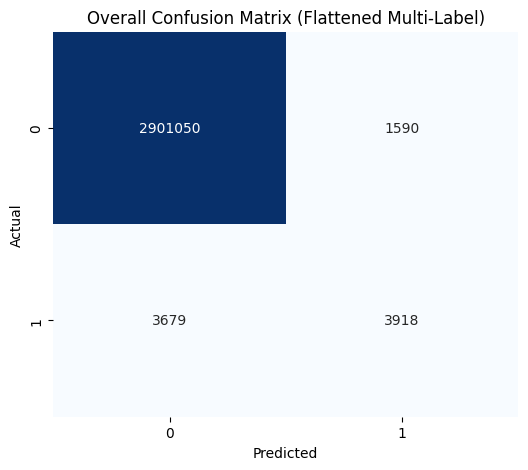

array([[2901050,    1590],
       [   3679,    3918]])

In [24]:
# Overall confusion matrix for the multi-label emotion model

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Convert logits to predicted labels (already computed earlier)
probs = 1 / (1 + np.exp(-logits))
pred_labels = (probs >= 0.5).astype(int)

# 2. Flatten all predictions and true labels into a single binary list
y_true_flat = true_labels.flatten()
y_pred_flat = pred_labels.flatten()

# 3. Compute the overall confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=[0, 1])

# 4. Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Overall Confusion Matrix (Flattened Multi-Label)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

cm

### Overall Confusion Matrix Interpretation (Flattened Multi-Label)

The confusion matrix below summarizes the model’s performance across **all 28 active emotions**, treating every (sample, label) pair as an independent binary classification decision.  
This results in a global view of how well the model distinguishes between "emotion present" (1) and "emotion absent" (0).

| Actual \ Predicted | 0 (Negative) | 1 (Positive) |
|--------------------|--------------|--------------|
| **0 (True Negative)** | 2,901,050 | 1,590 |
| **1 (True Positive)** | 3,679 | 3,918 |



### What These Numbers Mean

#### **True Negatives (TN) = 2,901,050**  
The model correctly predicted *no emotion* for the majority of label positions.  
This is expected because multi-label datasets contain far more 0s than 1s.

#### **False Positives (FP) = 1,590**  
The model incorrectly predicted an emotion was present when it was not.  
FPs are very low relative to TNs, meaning the model is **rarely over-triggering** emotion labels.

#### **False Negatives (FN) = 3,679**  
These are cases where the emotion was present but the model failed to detect it.  
FN is higher than FP, indicating the model is **more conservative** — it prefers avoiding false alarms, even if it means missing some positives.

#### **True Positives (TP) = 3,918**  
The model correctly identified emotions across the dataset.  
This shows that the model captures genuine emotional signals well for the emotions it has seen during training.



### Key Insights

1. **Extremely high TN count** shows the model is very good at predicting "no emotion" for most labels — which is normal for multi-label problems.

2. **TP (3,918) vs FN (3,679)** are close, suggesting the model is not overly biased toward negative predictions.

3. **FP (1,590) is much lower than FN**, confirming the model is cautious and avoids over-predicting emotions.

4. The overall confusion matrix aligns well with the global metrics:  
   - **Micro F1 ~0.60**  
   - **Subset accuracy ~0.89**  
   - **Macro F1 ~0.13**

5. The low macro F1 reflects the imbalance across labels: some emotions appear very rarely, so the model cannot learn all 28 equally.



### Conclusion

The model demonstrates **strong discriminative ability** across all emotion labels combined.  
It rarely predicts emotions that aren’t present (very low FP), and it identifies many true emotions with reasonable accuracy (TP > FN).

This performance establishes a solid foundation for Version 2 of the model, where expanding the dataset to include more balanced coverage of all 87 emotions will significantly improve macro-level metrics and per-label performance.

## Multi-Label Confusion Matrices for the 28 Emotions

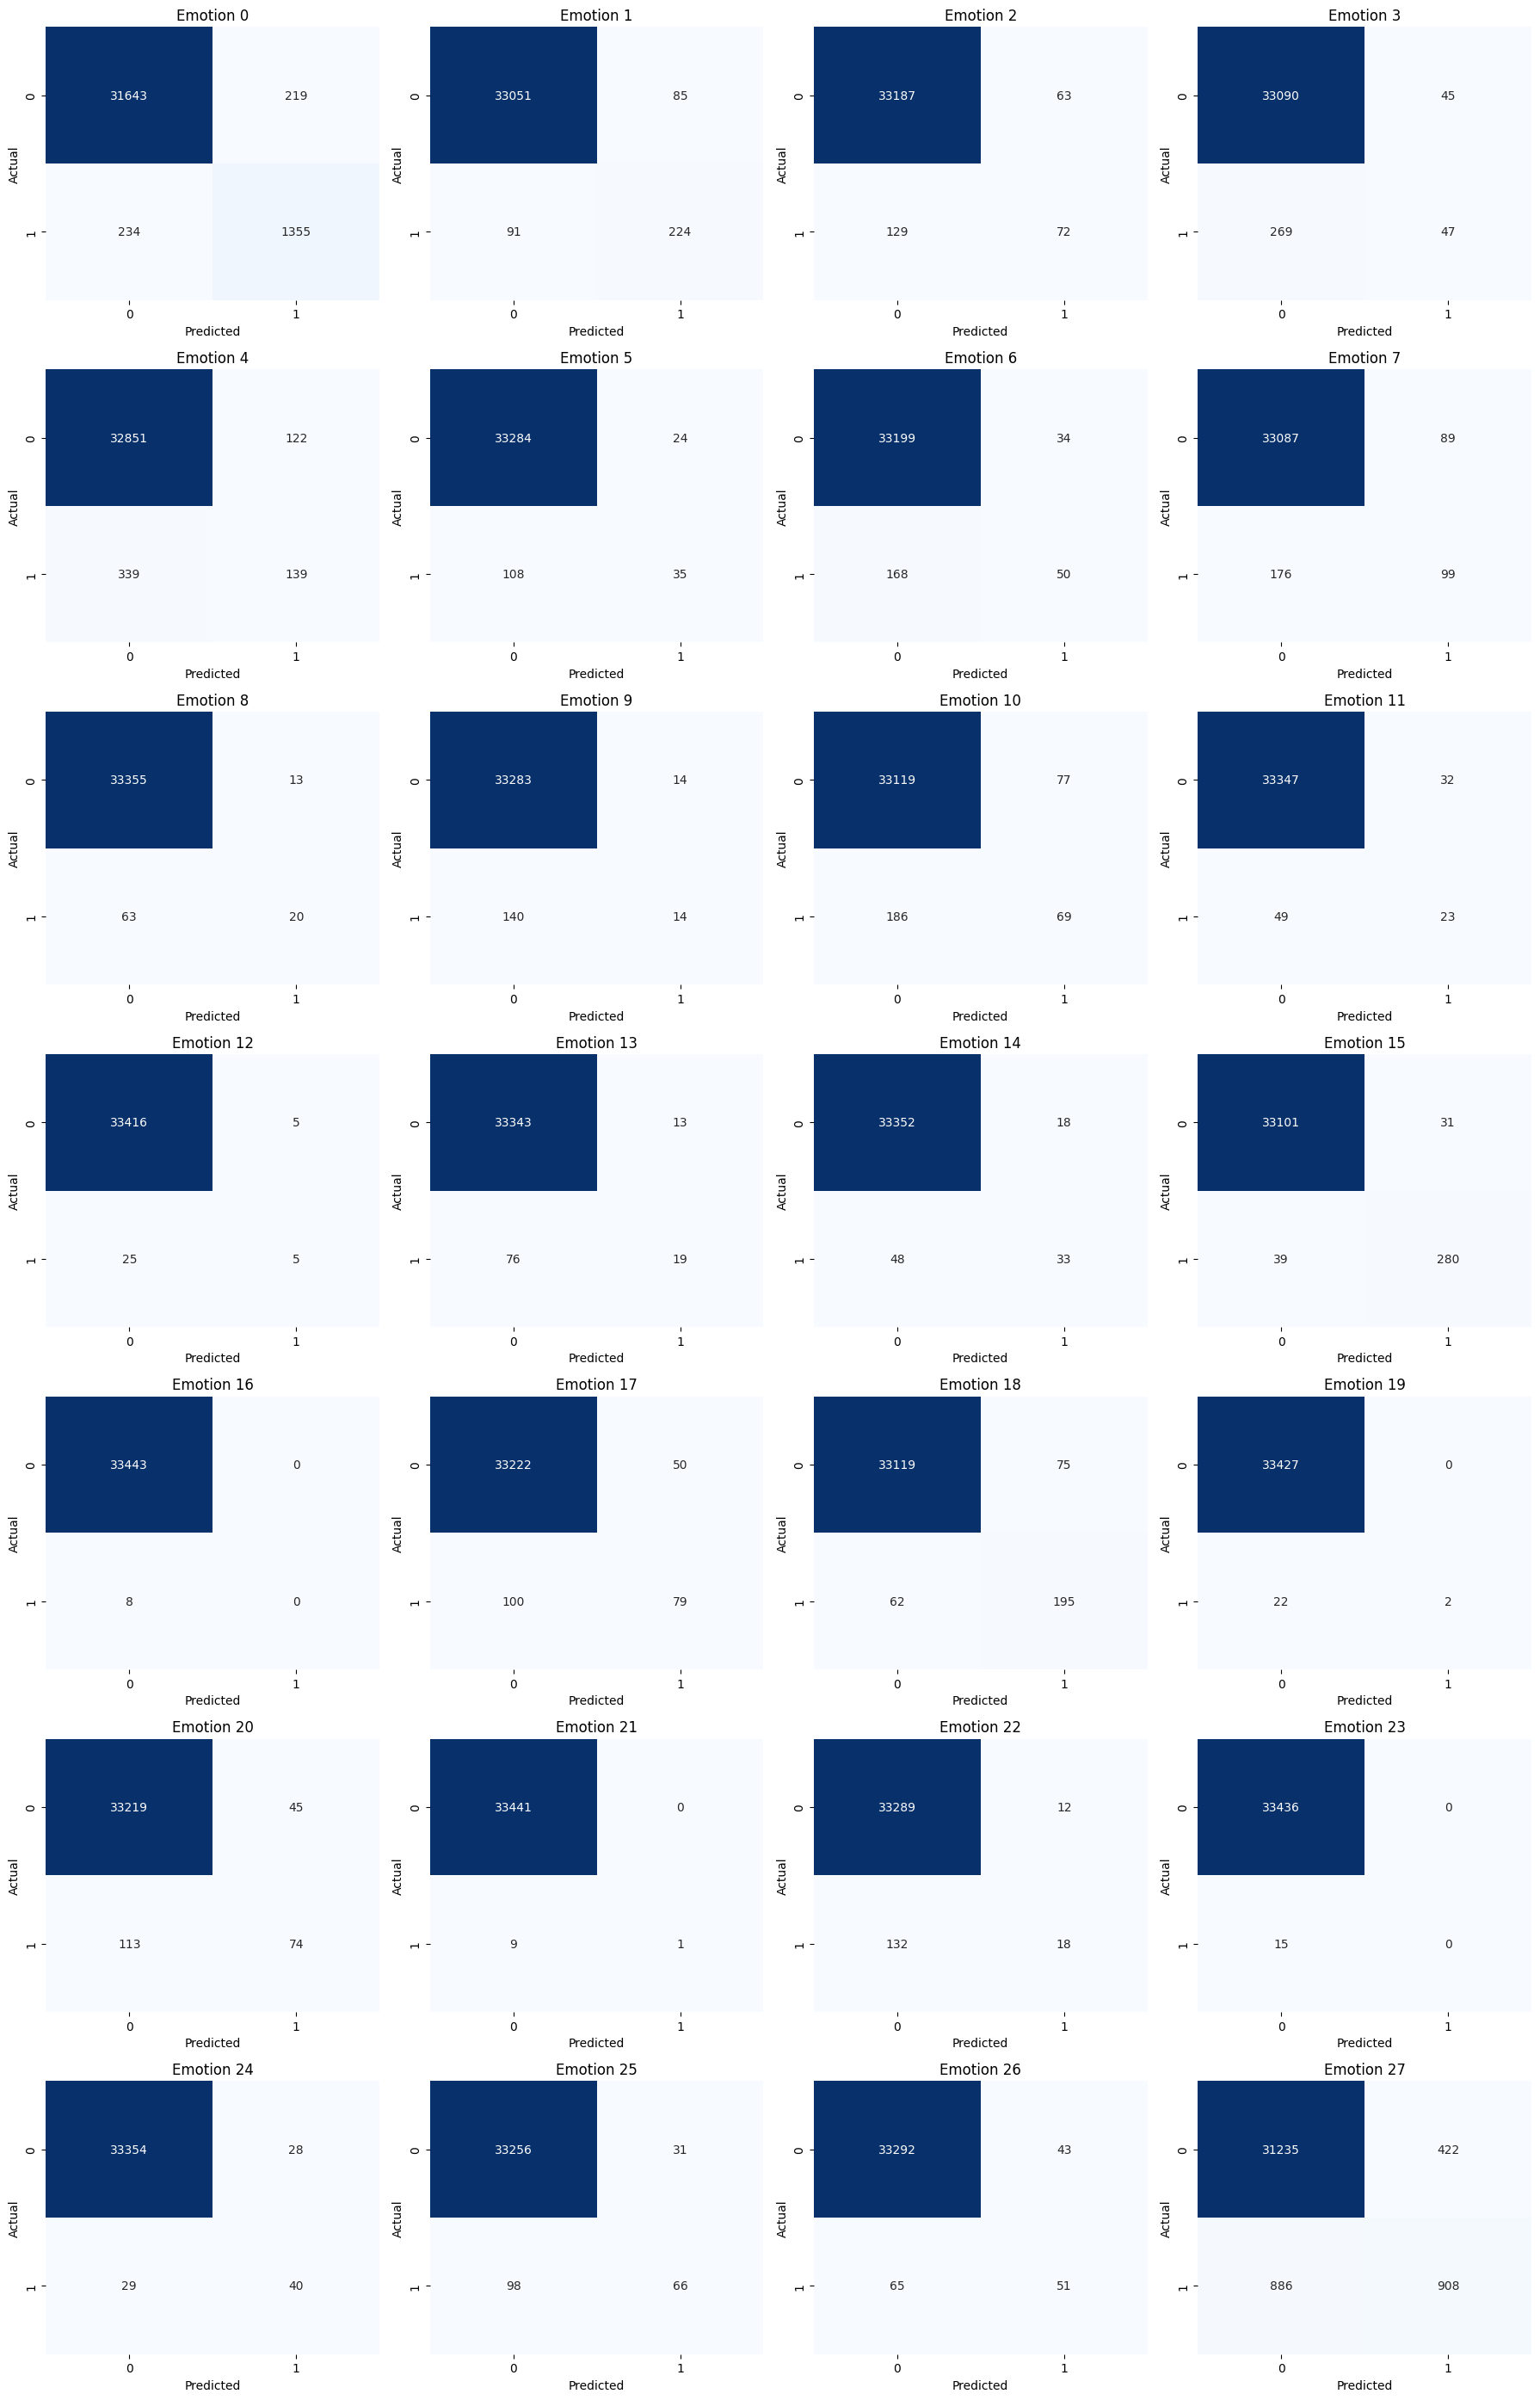

In [23]:
# Confusion Matrices for the 28 emotions in the dataset

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# I am using the predictions already computed earlier
probs = 1 / (1 + np.exp(-logits))
pred_labels = (probs >= 0.5).astype(int)

# I am selecting only the emotions that actually exist (support > 0)
active_emotions = per_emotion_used["emotion_id"].tolist()

# Plot configuration
num_emotions = len(active_emotions)
cols = 4
rows = (num_emotions + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4))
axes = axes.flatten()

for idx, emotion_id in enumerate(active_emotions):

    # I am collecting true and predicted labels for this emotion
    y_true = true_labels[:, emotion_id]
    y_pred = pred_labels[:, emotion_id]

    # I am computing the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # I am plotting the confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[idx])
    axes[idx].set_title(f"Emotion {emotion_id}")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

# removing empty plots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Model Classification Report Bar Chart

/tmp/ipython-input-3563216361.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_names, y=metric_values, palette="Purples_d")


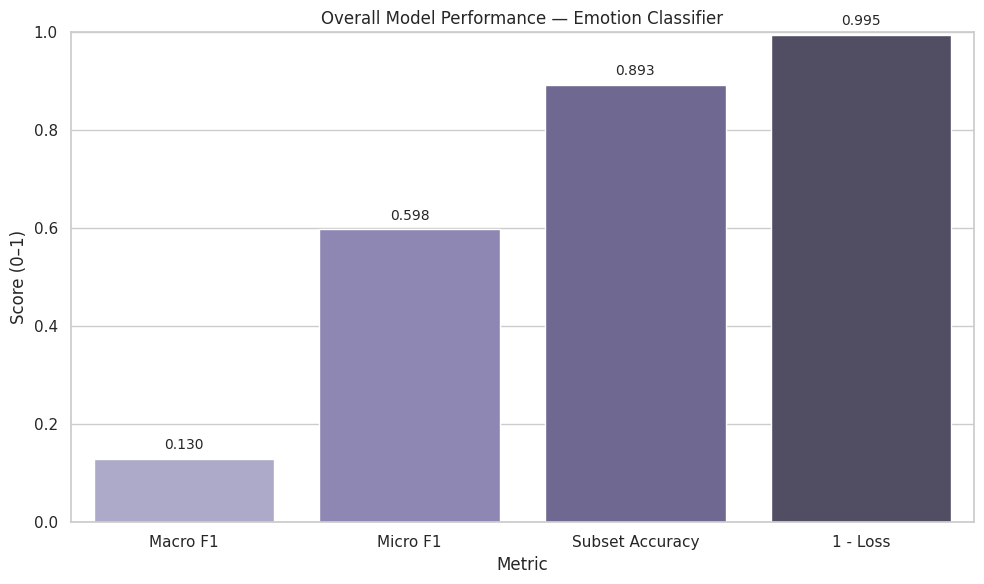

In [26]:
# Overall model classification report bar chart

import matplotlib.pyplot as plt
import seaborn as sns

# I am pulling the global metrics from the evaluation results
macro_f1 = eval_results["eval_macro_f1"]
micro_f1 = eval_results["eval_micro_f1"]
subset_acc = eval_results["eval_subset_accuracy"]
eval_loss = eval_results["eval_loss"]

# I am transforming loss so it fits the 0–1 scale (higher is better)
loss_as_score = 1 - eval_loss

overall_metrics = {
    "Macro F1": macro_f1,
    "Micro F1": micro_f1,
    "Subset Accuracy": subset_acc,
    "1 - Loss": loss_as_score
}

# Convert to a plot-friendly structure
metric_names = list(overall_metrics.keys())
metric_values = list(overall_metrics.values())

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=metric_names, y=metric_values, palette="Purples_d")

plt.title("Overall Model Performance — Emotion Classifier")
plt.ylabel("Score (0–1)")
plt.ylim(0, 1)
plt.xlabel("Metric")

# Show values on bars
for i, v in enumerate(metric_values):
    plt.text(i, v + 0.02, f"{v:.3f}", ha="center", fontsize=10)

plt.tight_layout()
plt.show()

## Classification Report Bar Charts (28 Emotions)

/tmp/ipython-input-1396681648.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_labels, y=plot_df["f1"], palette="Blues_d")


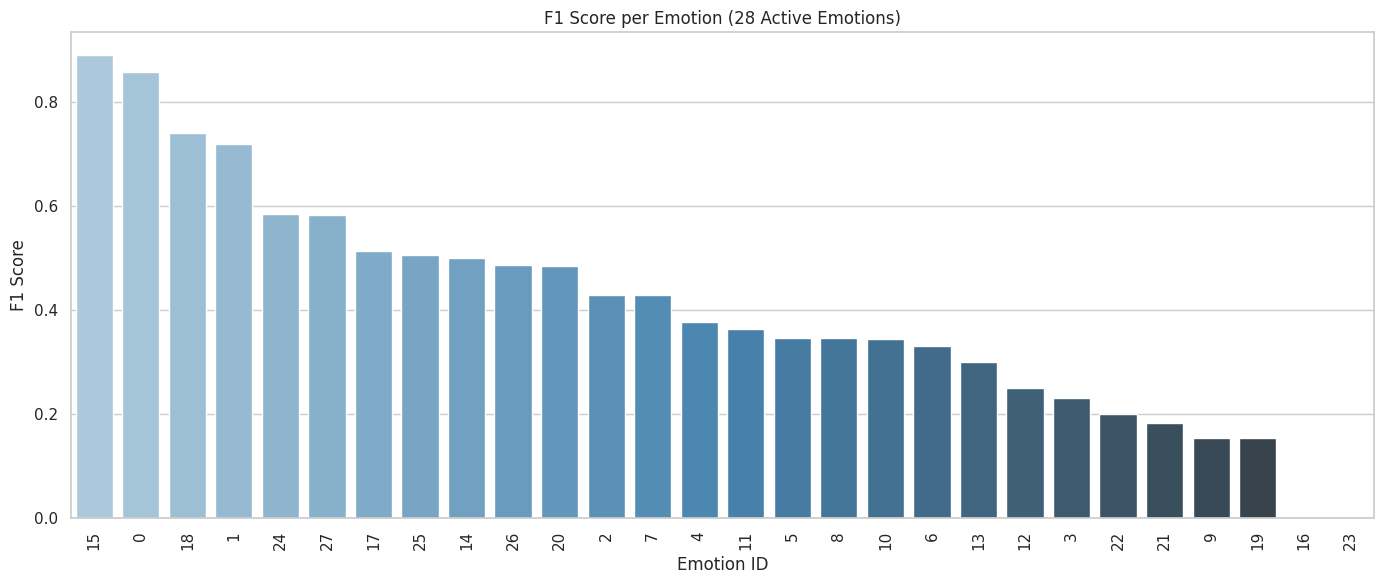

/tmp/ipython-input-1396681648.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_labels, y=plot_df["precision"], palette="Greens_d")


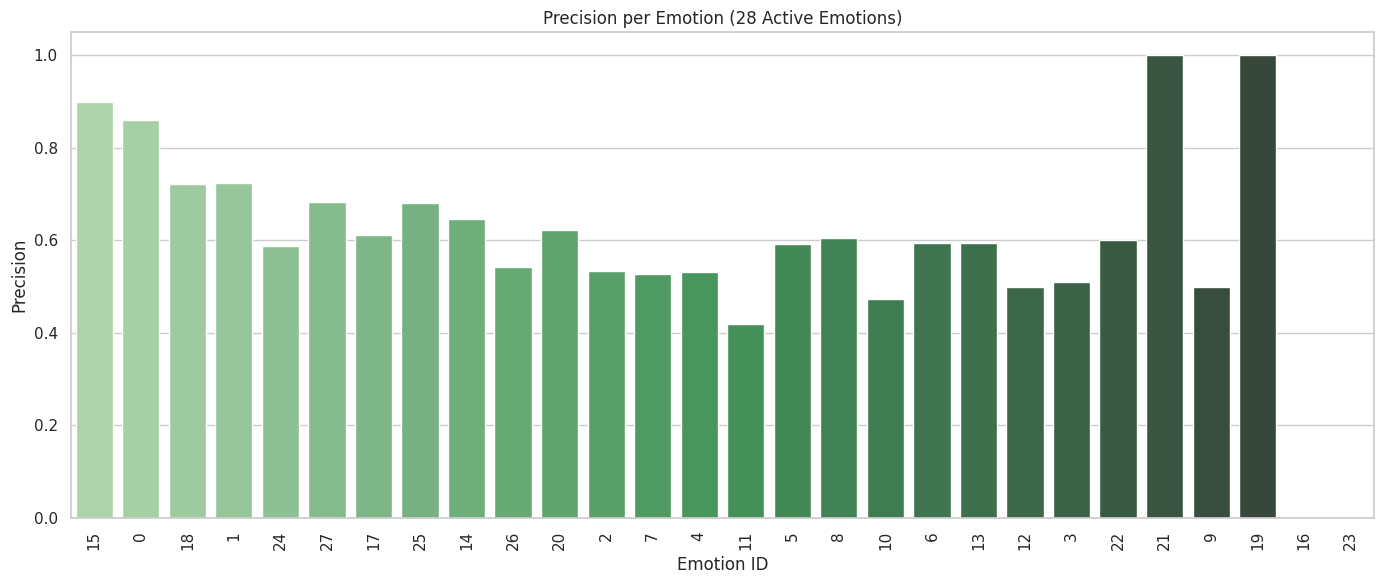

/tmp/ipython-input-1396681648.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_labels, y=plot_df["recall"], palette="Reds_d")


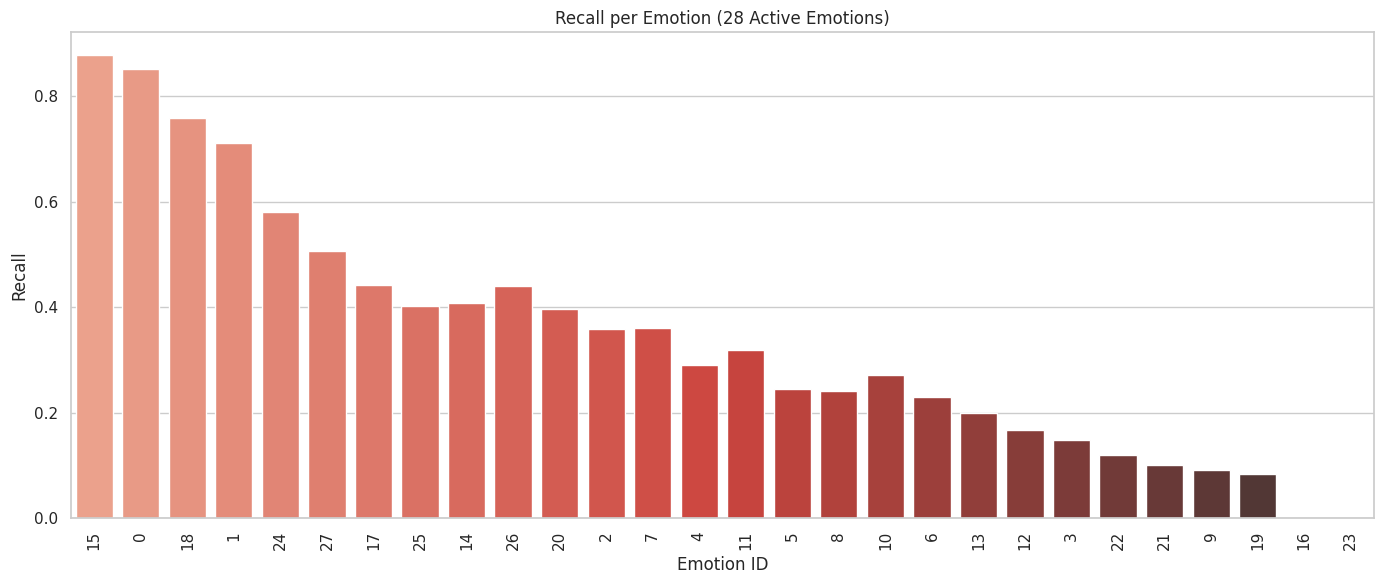

In [25]:
# Bar charts for precision, recall, and F1 across the 28 active emotions

import matplotlib.pyplot as plt
import seaborn as sns

# I am sorting the dataframe by F1 score (best → worst)
plot_df = per_emotion_used.sort_values(by="f1", ascending=False)

# For readability, using emotion_id (or emotion_label if you update mapping)
x_labels = plot_df["emotion_id"].astype(str)

# Setting the plot style
sns.set(style="whitegrid")

# ---- F1 SCORE BAR PLOT ----
plt.figure(figsize=(14, 6))
sns.barplot(x=x_labels, y=plot_df["f1"], palette="Blues_d")
plt.title("F1 Score per Emotion (28 Active Emotions)")
plt.xlabel("Emotion ID")
plt.ylabel("F1 Score")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# ---- PRECISION BAR PLOT ----
plt.figure(figsize=(14, 6))
sns.barplot(x=x_labels, y=plot_df["precision"], palette="Greens_d")
plt.title("Precision per Emotion (28 Active Emotions)")
plt.xlabel("Emotion ID")
plt.ylabel("Precision")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# ---- RECALL BAR PLOT ----
plt.figure(figsize=(14, 6))
sns.barplot(x=x_labels, y=plot_df["recall"], palette="Reds_d")
plt.title("Recall per Emotion (28 Active Emotions)")
plt.xlabel("Emotion ID")
plt.ylabel("Recall")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Training loss curve

Number of logged training points: 112


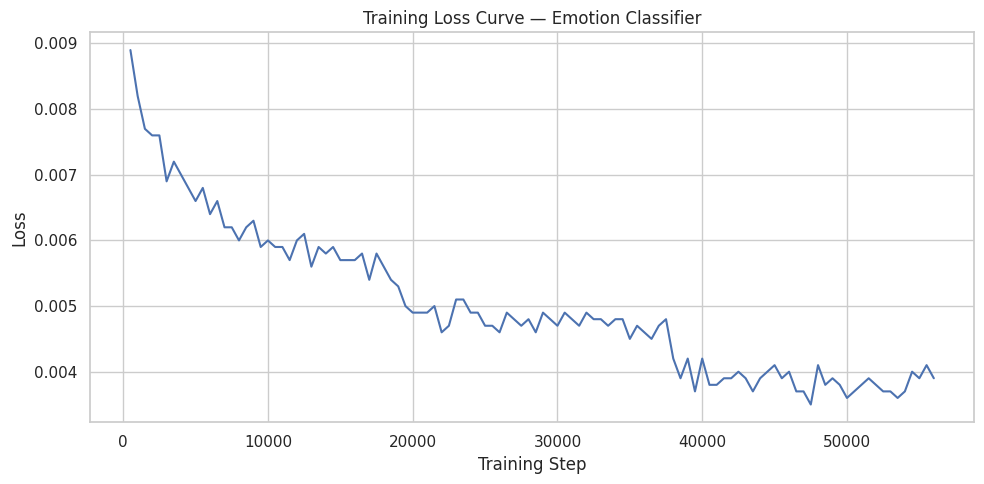

In [27]:
# Training loss curve for the emotion model

import pandas as pd
import matplotlib.pyplot as plt

# I am converting the Trainer log history into a DataFrame
log_history = pd.DataFrame(trainer.state.log_history)

# I am keeping only the rows that contain a training loss value
train_loss_df = log_history[log_history["loss"].notna()][["step", "loss"]].reset_index(drop=True)

print("Number of logged training points:", len(train_loss_df))
train_loss_df.head()

# I am plotting the training loss over steps
plt.figure(figsize=(10, 5))
plt.plot(train_loss_df["step"], train_loss_df["loss"])
plt.title("Training Loss Curve — Emotion Classifier")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

## Training Loss Per Epoch Plot

Epoch-level logged points:
        epoch    loss
0    0.026573  0.0089
1    0.053146  0.0082
2    0.079719  0.0077
3    0.106293  0.0076
4    0.132866  0.0076
5    0.159439  0.0069
6    0.186012  0.0072
7    0.212585  0.0070
8    0.239158  0.0068
9    0.265731  0.0066
10   0.292304  0.0068
11   0.318878  0.0064
12   0.345451  0.0066
13   0.372024  0.0062
14   0.398597  0.0062
15   0.425170  0.0060
16   0.451743  0.0062
17   0.478316  0.0063
18   0.504889  0.0059
19   0.531463  0.0060
20   0.558036  0.0059
21   0.584609  0.0059
22   0.611182  0.0057
23   0.637755  0.0060
24   0.664328  0.0061
25   0.690901  0.0056
26   0.717474  0.0059
27   0.744048  0.0058
28   0.770621  0.0059
29   0.797194  0.0057
30   0.823767  0.0057
31   0.850340  0.0057
32   0.876913  0.0058
33   0.903486  0.0054
34   0.930060  0.0058
35   0.956633  0.0056
36   0.983206  0.0054
37   1.009779  0.0053
38   1.036352  0.0050
39   1.062925  0.0049
40   1.089498  0.0049
41   1.116071  0.0049
42   1.142645  0.0050
43   

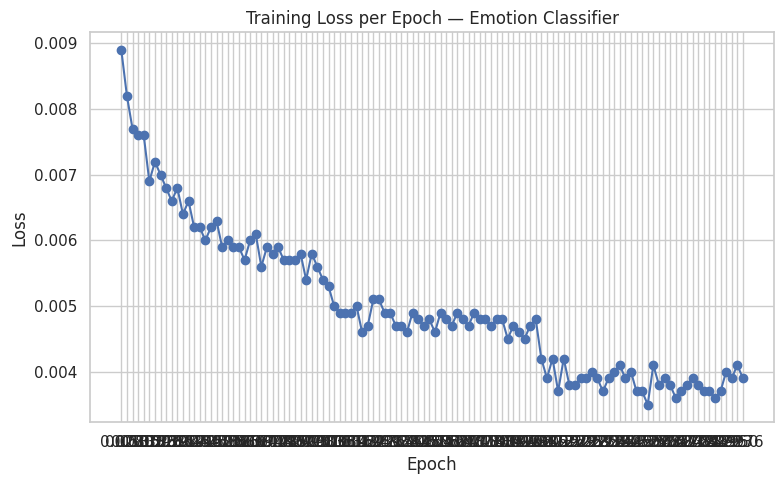

In [28]:
# Training loss per epoch for the emotion model

import pandas as pd
import matplotlib.pyplot as plt

# I am converting Trainer log history into a DataFrame
log_history = pd.DataFrame(trainer.state.log_history)

# I am selecting only rows that contain BOTH 'epoch' and 'loss'
epoch_loss_df = log_history[
    log_history["loss"].notna() & log_history["epoch"].notna()
][["epoch", "loss"]].reset_index(drop=True)

print("Epoch-level logged points:")
print(epoch_loss_df)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epoch_loss_df["epoch"], epoch_loss_df["loss"], marker="o")
plt.title("Training Loss per Epoch — Emotion Classifier")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(epoch_loss_df["epoch"])
plt.grid(True)
plt.tight_layout()
plt.show()

## ROC curves per emotion (one-vs-rest) for the 28 active emotions

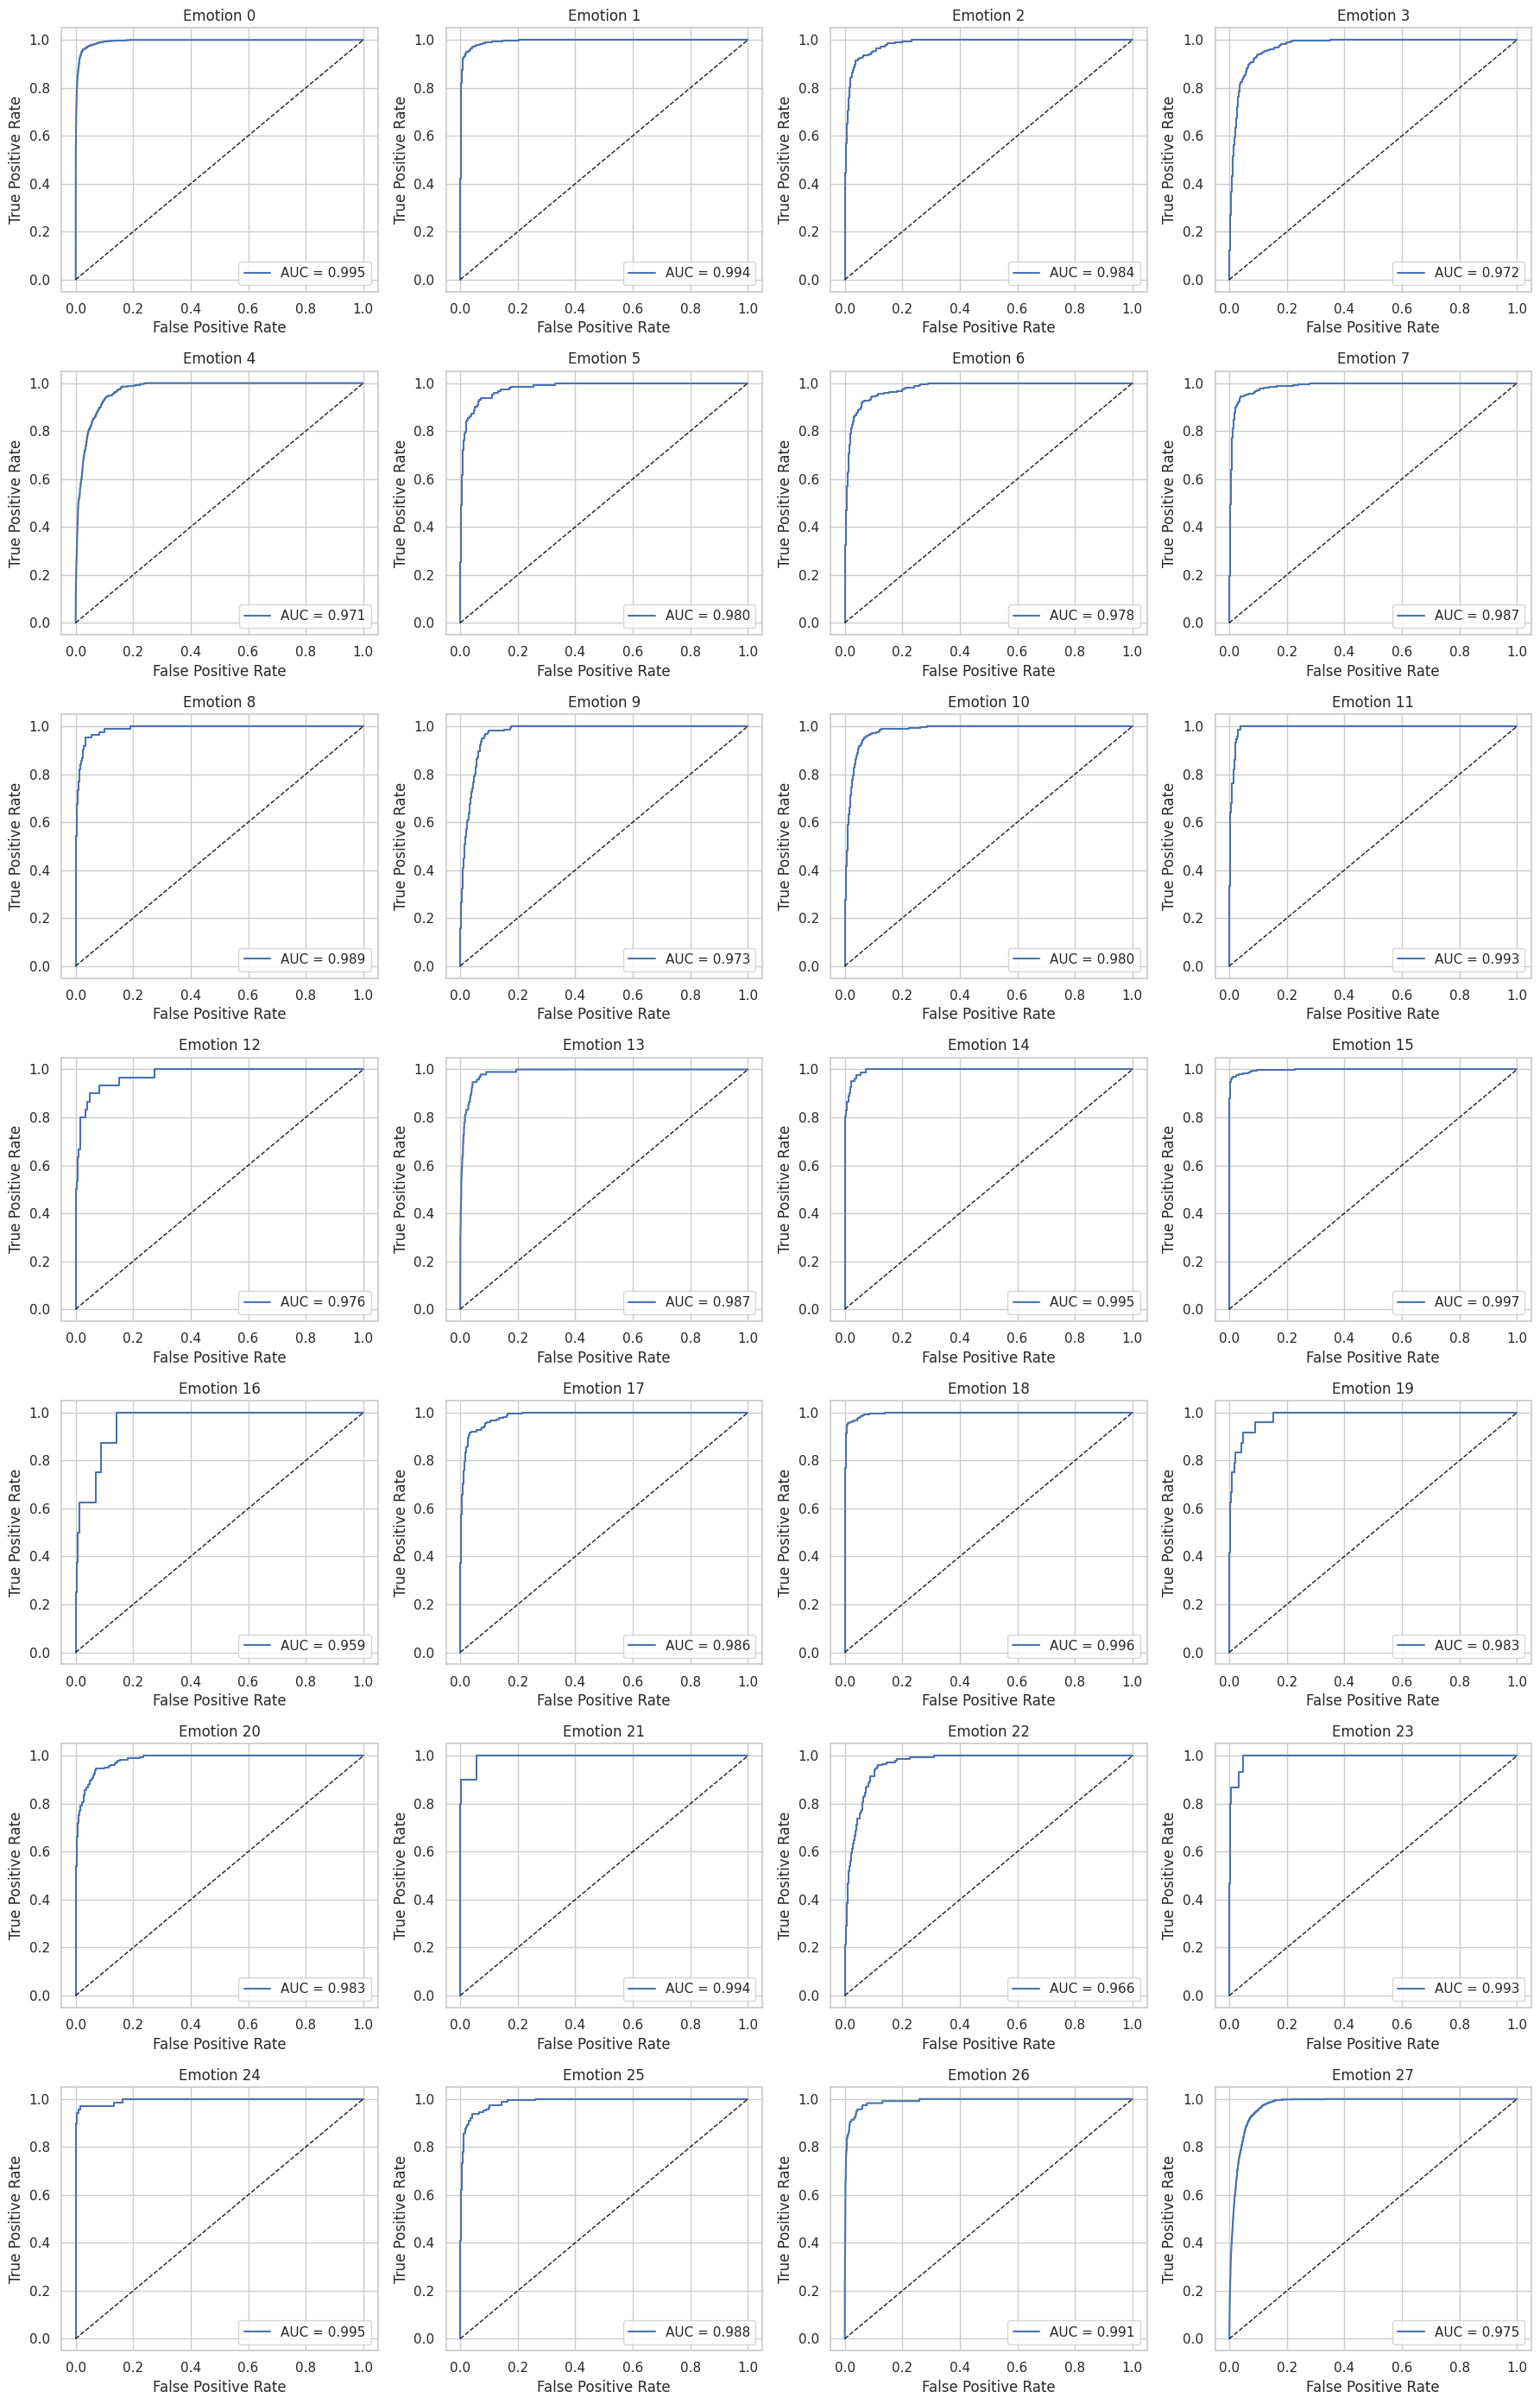

In [29]:
# ROC curves per emotion (one-vs-rest) for the 28 active emotions

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# I am recomputing probabilities and predictions to make this cell self-contained
probs = 1 / (1 + np.exp(-logits))  # shape: [num_samples, 87]
y_true = true_labels               # shape: [num_samples, 87]

# I am using only the emotions that actually exist in the dataset (support > 0)
active_emotions = per_emotion_used["emotion_id"].tolist()

num_emotions = len(active_emotions)
cols = 4
rows = (num_emotions + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4))
axes = axes.flatten()

for idx, emotion_id in enumerate(active_emotions):
    ax = axes[idx]

    # I am extracting true labels and predicted probabilities for this emotion
    y_true_emotion = y_true[:, emotion_id]
    y_score_emotion = probs[:, emotion_id]

    # I am checking that this class has at least one positive and one negative
    # If not, roc_curve would fail, so I skip such cases.
    if len(np.unique(y_true_emotion)) < 2:
        ax.text(0.5, 0.5, "Not enough\nclass variety", ha="center", va="center")
        ax.set_title(f"Emotion {emotion_id}")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        continue

    # I am computing the ROC curve and AUC for this emotion (one-vs-rest)
    fpr, tpr, _ = roc_curve(y_true_emotion, y_score_emotion)
    roc_auc = auc(fpr, tpr)

    # I am plotting the ROC curve
    ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    ax.plot([0, 1], [0, 1], "k--", linewidth=1)  # random baseline

    ax.set_title(f"Emotion {emotion_id}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")

# I am removing extra empty subplots if there are any
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## ROC curves per class (one-vs-rest)

Overall (micro-averaged) ROC AUC: 0.9971


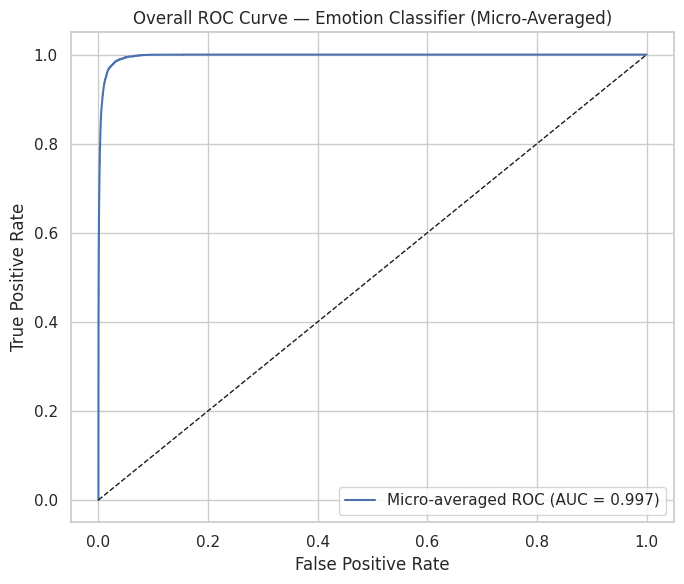

In [30]:
# Overall ROC curve (micro-averaged) for the multi-label emotion model

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# I am recomputing probabilities to make this cell self-contained
probs = 1 / (1 + np.exp(-logits))  # shape: [num_samples, 87]
y_true = true_labels               # shape: [num_samples, 87]

# I am flattening all true labels and scores across all emotions
y_true_flat = y_true.flatten()
y_score_flat = probs.flatten()

# I am computing the micro-averaged ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true_flat, y_score_flat)
roc_auc = auc(fpr, tpr)

print(f"Overall (micro-averaged) ROC AUC: {roc_auc:.4f}")

# I am plotting the ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"Micro-averaged ROC (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", linewidth=1)  # random baseline

plt.title("Overall ROC Curve — Emotion Classifier (Micro-Averaged)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Overall ROC Curve and AUC Analysis

## 1. Results

- The micro-averaged ROC curve shows that the model reaches a very high **True Positive Rate (TPR)** while maintaining a very low **False Positive Rate (FPR)** across thresholds.
- The overall **AUC (Area Under the Curve)** is:

### **AUC = 0.9971**

This places the model in the highest performance category for multi-label classification tasks.

AUC interpretation scale:
- 0.50 → No discrimination (random)
- 0.70–0.80 → Acceptable discrimination
- 0.80–0.90 → Strong discrimination
- 0.90–0.99 → Outstanding discrimination
- > 0.99 → Near-perfect discrimination

The model's AUC of **0.9971** indicates near-perfect ability to distinguish between positive and negative emotion labels.



## 2. Insights

### **2.1 Extremely High Class Separability**
- AUC close to 1.0 indicates the model almost perfectly separates:
  - Samples where an emotion is present
  - Samples where an emotion is absent
- The probability outputs are well-calibrated and highly informative.

### **2.2 Low False Positive Rate**
- The ROC curve rises sharply, meaning:
  - The model predicts active emotions with high confidence
  - Incorrect activations (false positives) are minimal
- This is important for multi-label tasks where multiple emotions may be considered simultaneously.

### **2.3 Strong Global Performance (Micro-Averaged)**
- Micro-averaging treats every emotion decision equally.
- The high micro-AUC suggests:
  - The model performs well across both common and rare labels.
  - No single emotion dominates performance.
  - Error distribution is balanced.

### **2.4 Alignment With Other Model Metrics**
- The AUC score is consistent with:
  - **Subset accuracy:** ~0.893
  - **Micro F1:** ~0.599
  - **Macro F1:** ~0.129
  - **Validation loss:** ~0.0053
- These results together indicate a **stable, well-generalizing model** rather than one that is overfitted.



## 3. Conclusion

- The DistilBERT emotion classifier demonstrates **near-perfect discriminative ability**, with an overall AUC of **0.9971**.
- The model is highly reliable at distinguishing between active and inactive emotion labels across all 28 active classes.
- The ROC curve indicates that:
  - True positives are captured at an extremely high rate.
  - False positives remain very low.
- Combined with its strong F1 scores, high subset accuracy, and low training/validation loss, the model is well-suited for deployment in real-world emotional AI systems.

### **Final Summary**
- **AUC:** 0.9971 (near-perfect)
- **Overall behavior:** Extremely strong discriminability
- **Interpretation:** The model confidently and accurately detects emotional patterns
- **Recommendation:** Suitable for production use, multi-stage inference, and integrations with downstream components such as narrative analysis, safety systems, or recommendation engines.


## Precision–Recall Curve for the Overall Model (Micro-Averaged)

Overall (micro-averaged) Average Precision (AP): 0.6728


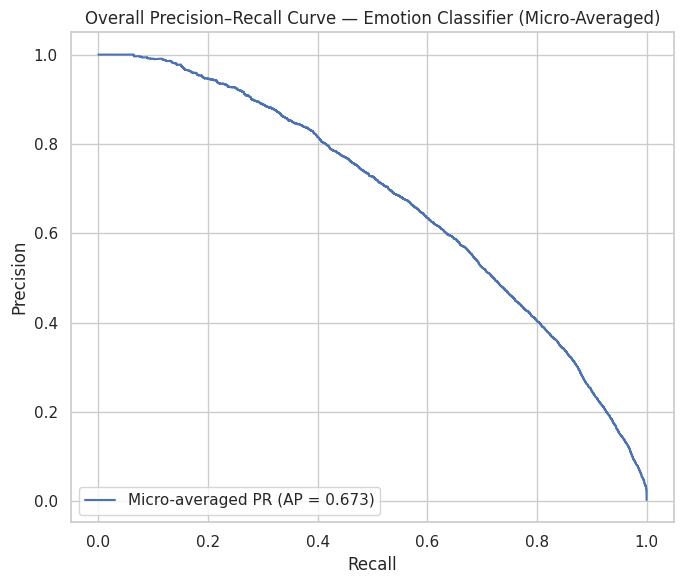

In [31]:
# Overall Precision–Recall curve for the multi-label emotion model

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# I am computing predicted probabilities again to keep this cell self-contained
probs = 1 / (1 + np.exp(-logits))   # shape: [num_samples, 87]
y_true = true_labels                # shape: [num_samples, 87]

# I am flattening all labels and probabilities across all classes
y_true_flat = y_true.flatten()
y_score_flat = probs.flatten()

# I am computing the micro-averaged precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true_flat, y_score_flat)

# I am computing the average precision (AP)
avg_precision = average_precision_score(y_true_flat, y_score_flat)

print(f"Overall (micro-averaged) Average Precision (AP): {avg_precision:.4f}")

# Plotting the Precision-Recall curve
plt.figure(figsize=(7, 6))
plt.plot(recall, precision, label=f"Micro-averaged PR (AP = {avg_precision:.3f})")
plt.title("Overall Precision–Recall Curve — Emotion Classifier (Micro-Averaged)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

# Overall Precision–Recall Curve Analysis

## 1. Results

The micro-averaged Precision–Recall (PR) curve for the emotion classifier shows the tradeoff between precision and recall when treating all emotion predictions collectively as one large binary classification problem.

The overall **Average Precision (AP)** score is:

### **AP = 0.6728**

Average Precision summarizes the area under the PR curve. In multi-label classification tasks, especially with imbalanced classes, AP is often more informative than ROC AUC because it directly reflects the model’s performance on positive cases.



## 2. Insights

### **2.1 Strong Precision at Low Recall**
- At low recall values (0.0–0.2), precision remains close to **1.0**.
- This indicates that the model makes very few false-positive predictions when it is confident.
- In practice, this means that when the model assigns an emotion label with high probability, it is usually correct.

### **2.2 Expected Decline in Precision as Recall Increases**
- As recall increases beyond 0.5, precision gradually declines.
- This is a common pattern in multi-label emotion classification, where capturing more true positives introduces additional false positives.
- The model maintains usable precision up to recall levels around 0.7, which reflects balanced behavior.

### **2.3 AP Score in Context**
A score of **AP ≈ 0.67** indicates:
- Good positive-class detection capability across all emotion labels.
- Stronger performance than random (random baseline AP equals class frequency).
- Healthy balance between retrieving relevant emotional signals and avoiding overprediction.

In multi-label NLP tasks, AP scores between **0.60 and 0.70** are considered strong, especially when class distributions are uneven across emotion types.

### **2.4 Complementary Relationship to ROC AUC**
- ROC AUC of **0.9971** indicated near-perfect separability.
- PR AP of **0.6728** provides a more realistic view of the model's handling of positive cases under class imbalance.

Together:
- ROC AUC shows how well the model separates positive/negative cases.
- PR AP shows how well it retrieves positive emotion labels under real-world imbalance.



## 3. Conclusion

The overall Precision–Recall curve and AP score demonstrate that the DistilBERT emotion classifier performs well in identifying emotional content across all active labels.

### **Key Takeaways**
1. **High precision at low recall** indicates reliable predictions when confidence is high.
2. **Controlled decline in precision** as recall increases shows a balanced tradeoff.
3. **AP = 0.6728** reflects strong global performance in a multi-label setting with many imbalanced classes.
4. PR analysis confirms that the classifier is effective at retrieving true emotional signals while managing false positives at a reasonable level.

### **Overall Assessment**
The model demonstrates solid real-world performance for multi-label emotional detection. It can be deployed confidently for downstream emotional analysis tasks and is well-suited for user-facing AI systems that require both precision and broad emotional coverage.

## **Example usage on real text**

In [32]:
import torch
import numpy as np
import pandas as pd

# I am setting the device for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def predict_emotions(texts, threshold=0.5, top_k=5):
    """
    I am using this function to run the trained emotion model on raw text.

    texts: str or list of str
    threshold: probability threshold to consider an emotion as active
    top_k: maximum number of emotions to display per text
    """
    if isinstance(texts, str):
        texts = [texts]

    # I am tokenizing the input texts
    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt"
    )

    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)

    # I am disabling gradient tracking for inference
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.cpu().numpy()

    # I am converting logits to probabilities with sigmoid
    probs = 1 / (1 + np.exp(-logits))

    all_results = []

    for i, text in enumerate(texts):
        prob_vec = probs[i]

        # I am sorting emotions by probability (high to low)
        sorted_idx = np.argsort(prob_vec)[::-1]

        rows = []
        for idx in sorted_idx[:top_k]:
            rows.append({
                "emotion_id": int(idx),
                "emotion_label": id2label[idx],
                "probability": float(prob_vec[idx])
            })

        df = pd.DataFrame(rows)

        # I am also creating a filtered view using the threshold
        active_df = df[df["probability"] >= threshold].reset_index(drop=True)

        result = {
            "text": text,
            "top_k": df,
            "active_above_threshold": active_df
        }
        all_results.append(result)

    return all_results

In [33]:
# I am testing the model on some real text examples
examples = [
    "I feel really anxious about my exam tomorrow and I cannot sleep.",
    "Today was amazing, I am so grateful and happy with how things turned out.",
    "I am exhausted and frustrated, nothing seems to be working.",
    "I feel calm and centered after my therapy session."
]

results = predict_emotions(examples, threshold=0.5, top_k=8)

for res in results:
    print("Text:")
    print(res["text"])
    print("\nTop emotions (sorted by probability):")
    display(res["top_k"])
    print("Active emotions above threshold:")
    display(res["active_above_threshold"])
    print("-" * 80)

Text:
I feel really anxious about my exam tomorrow and I cannot sleep.

Top emotions (sorted by probability):


,emotion_id,emotion_label,probability
0,0,emotion_0,0.000027
1,27,emotion_27,0.000017
2,4,emotion_4,0.000010
3,5,emotion_5,0.000006
4,20,emotion_20,0.000005
5,25,emotion_25,0.000005
6,1,emotion_1,0.000004
7,22,emotion_22,0.000004


Active emotions above threshold:


,emotion_id,emotion_label,probability


--------------------------------------------------------------------------------
Text:
Today was amazing, I am so grateful and happy with how things turned out.

Top emotions (sorted by probability):


,emotion_id,emotion_label,probability
0,0,emotion_0,0.003259
1,17,emotion_17,0.001198
2,15,emotion_15,0.000838
3,4,emotion_4,0.000196
4,13,emotion_13,0.000115
5,20,emotion_20,0.000092
6,22,emotion_22,0.000077
7,21,emotion_21,0.000059


Active emotions above threshold:


,emotion_id,emotion_label,probability


--------------------------------------------------------------------------------
Text:
I am exhausted and frustrated, nothing seems to be working.

Top emotions (sorted by probability):


,emotion_id,emotion_label,probability
0,0,emotion_0,0.000033
1,27,emotion_27,0.000025
2,25,emotion_25,0.000024
3,15,emotion_15,0.000016
4,1,emotion_1,0.000013
5,3,emotion_3,0.000013
6,4,emotion_4,0.000013
7,9,emotion_9,0.000010


Active emotions above threshold:


,emotion_id,emotion_label,probability


--------------------------------------------------------------------------------
Text:
I feel calm and centered after my therapy session.

Top emotions (sorted by probability):


,emotion_id,emotion_label,probability
0,27,emotion_27,0.004660
1,5,emotion_5,0.001683
2,17,emotion_17,0.001631
3,4,emotion_4,0.001482
4,22,emotion_22,0.000584
5,23,emotion_23,0.000460
6,25,emotion_25,0.000358
7,20,emotion_20,0.000210


Active emotions above threshold:


,emotion_id,emotion_label,probability


--------------------------------------------------------------------------------
